### **Objective**

In this notebook, we will implement k-means algorithm using `sklearn`.

### **Importing Libraries**

In [1]:
from IPython.display import display, Math, Latex
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns; sns.set()

from sklearn.cluster import KMeans

from sklearn.datasets import load_digits

from sklearn.metrics import silhouette_score

from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

import warnings 
warnings.filterwarnings('ignore')

### **Clustering of digits** 

We will use digit dataset for clustering, which is loaded through the `load_digits` API.

* It loads `8x8` digit images with approximately **180 samples per class**.

* From 10 classes, it has **total of 1797 images**.

* Each pixel has value **between 0 and 16**.

In [2]:
digits = load_digits()

In [3]:
data = np.column_stack((digits.data, digits.target))
columns = np.append(digits.feature_names, ['targets'])

df_digits = pd.DataFrame(data, columns=columns)

In [4]:
df_digits.head()

,pixel_0_0,pixel_0_1,pixel_0_2,pixel_0_3,pixel_0_4,pixel_0_5,pixel_0_6,pixel_0_7,pixel_1_0,pixel_1_1,...,pixel_6_7,pixel_7_0,pixel_7_1,pixel_7_2,pixel_7_3,pixel_7_4,pixel_7_5,pixel_7_6,pixel_7_7,targets
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,11.0,16.0,10.0,0.0,0.0,1.0
2,0.0,0.0,0.0,4.0,15.0,12.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,11.0,16.0,9.0,0.0,2.0
3,0.0,0.0,7.0,15.0,13.0,1.0,0.0,0.0,0.0,8.0,...,0.0,0.0,0.0,7.0,13.0,13.0,9.0,0.0,0.0,3.0
4,0.0,0.0,0.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,16.0,4.0,0.0,0.0,4.0


In [5]:
df_digits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1797 entries, 0 to 1796
Data columns (total 65 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pixel_0_0  1797 non-null   float64
 1   pixel_0_1  1797 non-null   float64
 2   pixel_0_2  1797 non-null   float64
 3   pixel_0_3  1797 non-null   float64
 4   pixel_0_4  1797 non-null   float64
 5   pixel_0_5  1797 non-null   float64
 6   pixel_0_6  1797 non-null   float64
 7   pixel_0_7  1797 non-null   float64
 8   pixel_1_0  1797 non-null   float64
 9   pixel_1_1  1797 non-null   float64
 10  pixel_1_2  1797 non-null   float64
 11  pixel_1_3  1797 non-null   float64
 12  pixel_1_4  1797 non-null   float64
 13  pixel_1_5  1797 non-null   float64
 14  pixel_1_6  1797 non-null   float64
 15  pixel_1_7  1797 non-null   float64
 16  pixel_2_0  1797 non-null   float64
 17  pixel_2_1  1797 non-null   float64
 18  pixel_2_2  1797 non-null   float64
 19  pixel_2_3  1797 non-null   float64
 20  pixel_2_

Some of the important parameters of KMeans are as follows : 
* `init`

* `n_init`

* `max_iter`

* `random_state`

Since `KMeans` algorithm is susceptible to local minima, we perform multiple `KMeans` fit and select the ones with the lowest value of sum of squared error.

* The total number of time, we would like to run `KMeans` algorithm is specified through `n_init` parameter.

* `max_iter` specifies total number of iterations to perform before declaring the convergence.



Let's define parameters of KMeans clustering algorithm in a dictionary object.

In [6]:
kmeans_kwargs = {
    'init': 'random',
    'n_init': 50,
    'max_iter': 500,
    'random_state': 0
}

### **Model Building**

Let's define a `pipeline` with two stages : 

* preprocessing for feature scaling with `MinMaxScaler`.

* clustering with `KMeans` clustering algorithm.

In [7]:
pipeline = Pipeline([('scaler', MinMaxScaler()),
                     ('clustering', KMeans(n_clusters=10, **kmeans_kwargs))])

pipeline.fit(digits.data)

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('clustering',
                 KMeans(init='random', max_iter=500, n_clusters=10, n_init=50,
                        random_state=0))])

The cluster centroids can be accessed via `cluster_centers_` member variable of `KMeans` class


In [8]:
cluster_centers = pipeline[-1].cluster_centers_
cluster_centers.shape

(10, 64)

##### **Dispalying the cluster centroids.**

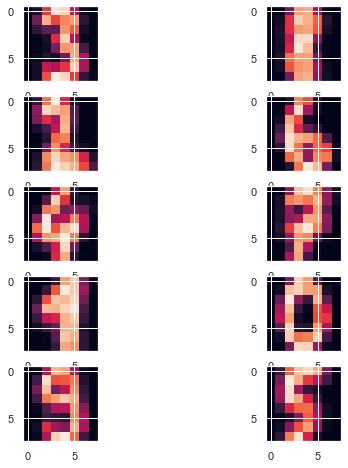

In [9]:
fig, ax = plt.subplots(5, 2, figsize=(8,8))
for i, j in zip(ax.flat, cluster_centers.reshape(10, 8, 8)):
    i.imshow(j)

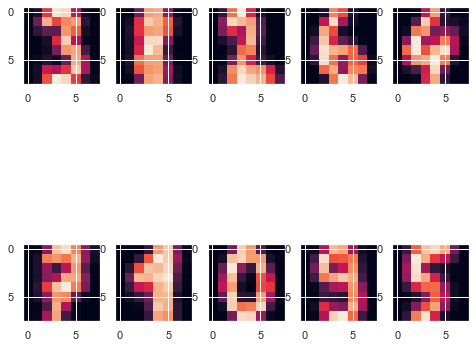

In [10]:
fig, ax = plt.subplots(2, 5, figsize=(8,8))
for i, j in zip(ax.flat, cluster_centers.reshape(10, 8, 8)):
    i.imshow(j)

In this case, the number of clusters were known, hence we set k=10 and got the clusters.

##### For deciding the optimal number of clusters through **elbow and silhouette**, we will pretend that we do not know the clusters in the data and we will try to discover the optimal number of clusters through these two methods one by one:

### **Elbow method** 

Here we keep track of sum-of-squared error (SSE) in a list for each value of `k`.

In [11]:
sse_digit = []
scaled_digits = MinMaxScaler().fit_transform(digits.data)

for k in range(1, 12):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scaled_digits)
    sse_digit.append(kmeans.inertia_)

Note that the SSE for a given clustering output is obtained through `inertia_`.

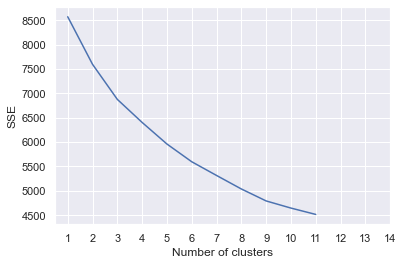

In [12]:
plt.plot(range(1, 12), sse_digit)
plt.xticks(range(1, 15))
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.show()


There is a slight elbow at **k=9**, which could point to the fact that a few digits may have been merged in one cluster.

### **Silhoutte Score**

In [13]:
sil_coef_digits = []
for k in range(2, 15):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scaled_digits)
    score = silhouette_score(digits.data, kmeans.labels_)
    sil_coef_digits.append(score)

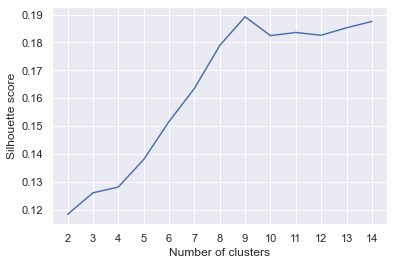

In [14]:
plt.plot(range(2, 15), sil_coef_digits)
plt.xticks(range(2, 15))

plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.grid(True)
plt.show()

Get the value of K for which the Silhouette coefficient is the highest.

In [15]:
# 2 is added since iteration is starting at 2.
print(np.argmax(sil_coef_digits) + 2) 

9
